#Classification of FashionMNSIT Dataset Using Convolutional Neural Networks and K Nearest Neighbors

In [42]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, Precision, Recall, F1Score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from IPython.display import display
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.datasets import fashion_mnist
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_predict, KFold
from tensorflow.keras.callbacks import History

# About the Dataset
Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels (see above) and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

#### Labels

Each training and test example is assigned to one of the following labels:

1. T-shirt/top
2. Trouser
3. Pullover
4. Dress
5. Coat
6. Sandal
7. Shirt
8. Sneaker
9. Bag
10. Ankle boot


In [22]:
# Loading the Dataset
data = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = data.load_data()

# Exploratory Data Analysis (EDA)

### Data Exploration

In [23]:
num_samples_train = len(train_labels)
num_samples_test = len(test_labels)

print("Number of samples in Training Dataset: {}".format(num_samples_train))
print("Number of samples in Testing Dataset: {}".format(num_samples_test))
print()
print("Shape of the Training Dataset: {}".format(train_images.shape))
print("Shape of the Testing Dataset: {}".format(test_images.shape))
print()

all_images = np.concatenate((train_images, test_images))

max_pixel_value = all_images.max()
min_pixel_value = all_images.min()

print("Maximum pixel value in the Fashion MNIST dataset:", max_pixel_value)
print("Minimum pixel value in the Fashion MNIST dataset:", min_pixel_value)

Number of samples in Training Dataset: 60000
Number of samples in Testing Dataset: 10000

Shape of the Training Dataset: (60000, 28, 28)
Shape of the Testing Dataset: (10000, 28, 28)

Maximum pixel value in the Fashion MNIST dataset: 255
Minimum pixel value in the Fashion MNIST dataset: 0


In [24]:
all_labels = np.concatenate((train_labels, test_labels))

samples_per_class = np.bincount(all_labels)
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

df_samples_per_class = pd.DataFrame({
    'Class Label': class_labels,
    'Number of Samples': samples_per_class
})

print(df_samples_per_class)

   Class Label  Number of Samples
0  T-shirt/top               7000
1      Trouser               7000
2     Pullover               7000
3        Dress               7000
4         Coat               7000
5       Sandal               7000
6        Shirt               7000
7      Sneaker               7000
8          Bag               7000
9   Ankle boot               7000


###Data Visualization

In [25]:
num_samples = 5
flattened_images = train_images[:num_samples].reshape(num_samples, -1)
df = pd.DataFrame(flattened_images)

df['Numeric Labels'] = train_labels[:num_samples]  # Add the integer labels
df['Class Labels'] = df['Numeric Labels'].apply(lambda x: class_labels[x])

display(df.head())

,0,1,2,3,4,5,6,7,8,9,...,776,777,778,779,780,781,782,783,Numeric Labels,Class Labels
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,Ankle boot
1,0,0,0,0,0,1,0,0,0,0,...,130,76,0,0,0,0,0,0,0,T-shirt/top
2,0,0,0,0,0,0,0,0,0,22,...,1,0,0,0,0,0,0,0,0,T-shirt/top
3,0,0,0,0,0,0,0,0,33,96,...,0,0,0,0,0,0,0,0,3,Dress
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,T-shirt/top



This table provides a structured representation of a subset of the FashionMNIST dataset. Each row represntes a single image, with 784 columns corresponding to the flattened pixel values from the original 28x28 grayscale image. The final column, labeled 'label', identifies the type of fashion item depicted in the image, with descriptive names such as 'T-shirt/top', 'Trouser', 'Sandal', etc.

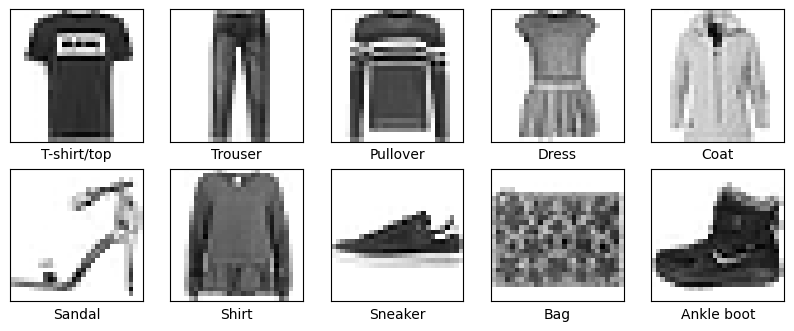

In [26]:
plt.figure(figsize=(10, 10))
for i in range(len(class_labels)):
    index = np.where(train_labels == i)[0][0]
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[index], cmap=plt.cm.binary)
    plt.xlabel(class_labels[i])
plt.show()

### Proprocessing the Data

In [27]:
#Checking for Null values in the dataset
print("Null values in training set images:", np.isnan(train_images).sum())
print("Null values in test set images:", np.isnan(test_images).sum())
print("Null values in training set labels:", np.isnan(train_images).sum())
print("Null values in test set labels:", np.isnan(train_images).sum())
print()

#Normalization
train_images = train_images / 255.0
test_images = test_images / 255.0

# Reshaping the data to add a channel dimension for KNN
train_images_knn = train_images.reshape((60000, 28 * 28)).astype('float32')
test_images_knn = test_images.reshape((10000, 28 * 28)).astype('float32')

# Reshaping the data to add a channel dimension for CNN
train_images_cnn = train_images.reshape((num_samples_train, 28, 28, 1))
test_images_cnn = test_images.reshape((num_samples_test, 28, 28, 1))

# Data Splitting: Splitting the dataset into Train, Validation and Test Datasets
train_images_cnn, val_images_cnn, train_labels_cnn, val_labels_cnn = train_test_split(
    train_images_cnn, train_labels, test_size=0.2, random_state=42)
print("Shape of the respective datasetes after Data Splitting:")
print(train_images_cnn.shape, test_images_cnn.shape, val_images_cnn.shape)
print()

# One Hot Encoding
train_labels_one_hot = to_categorical(train_labels_cnn, num_classes=10)
val_labels_one_hot = to_categorical(val_labels_cnn, num_classes=10)
test_labels_one_hot = to_categorical(test_labels, num_classes=10)
print("Shape of the labels after One Hot Encoding:")
print(train_labels_one_hot.shape, test_labels_one_hot.shape, val_labels_one_hot.shape)

Null values in training set images: 0
Null values in test set images: 0
Null values in training set labels: 0
Null values in test set labels: 0

Shape of the respective datasetes after Data Splitting:
(48000, 28, 28, 1) (10000, 28, 28, 1) (12000, 28, 28, 1)

Shape of the labels after One Hot Encoding:
(48000, 10) (10000, 10) (12000, 10)


## K Nearest Neighbours

**Algorithm Selection**

*   It's a versatile algorithm that can handle different types of data and is adaptable to various scenarios.
*   KNN does not make any assumptions about the underlying data distribution, making it particularly useful when the data distribution is not well understood or non-linear.


*   KNN's hyperparameter, such as the number of neighbors (n_neighbors), provides flexibility. Techniques like cross-validation can be used to find the optimal value, as demonstrated in the provided code.

*   KNN can serve as a baseline model to compare against more complex algorithms. It helps establish a benchmark for evaluating the performance of other sophisticated models.


##Model Building

Hyperparameter tuning:
*   A range of 'n_neighbors' values (from 3 to 11) is defined to explore different settings for the KNN model.
*   The n_neighbors value that results in the highest average accuracy across folds is selected as the best parameter for the KNN classifier.

Testing and Evaluation:
*   K-Fold cross-validation (with 5 folds) is used to evaluate model performance for each 'n_neighbors' value. This ensures a robust estimation of how well the model might generalize to unseen data. Please see the experiments section.

*   Various performance metrics (accuracy, precision, recall, and F1-score) are computed based on the predicted and actual labels of the test set.








In [35]:
# Train the KNN classifier based on the Optimal Value of K obtained in the experiments section
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_images_knn, train_labels)

KNeighborsClassifier()

In [36]:
test_pred = knn_classifier.predict(test_images_knn)

# Calculate metrics for the test set using the loaded model
test_accuracy = accuracy_score(test_labels, test_pred)
test_loss = 1 - test_accuracy
test_precision = precision_score(test_labels, test_pred, average='weighted')
test_recall= recall_score(test_labels, test_pred, average='weighted')
test_f1 = f1_score(test_labels, test_pred, average='weighted')

print(f'Test Accuracy: {test_accuracy}')
print(f'Test Loss: {test_loss}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Test F1-score: {test_f1}')


Test Accuracy: 0.8554
Test Loss: 0.14459999999999995
Test Precision: 0.8578152450755355
Test Recall: 0.8554
Test F1-score: 0.8546439722018904


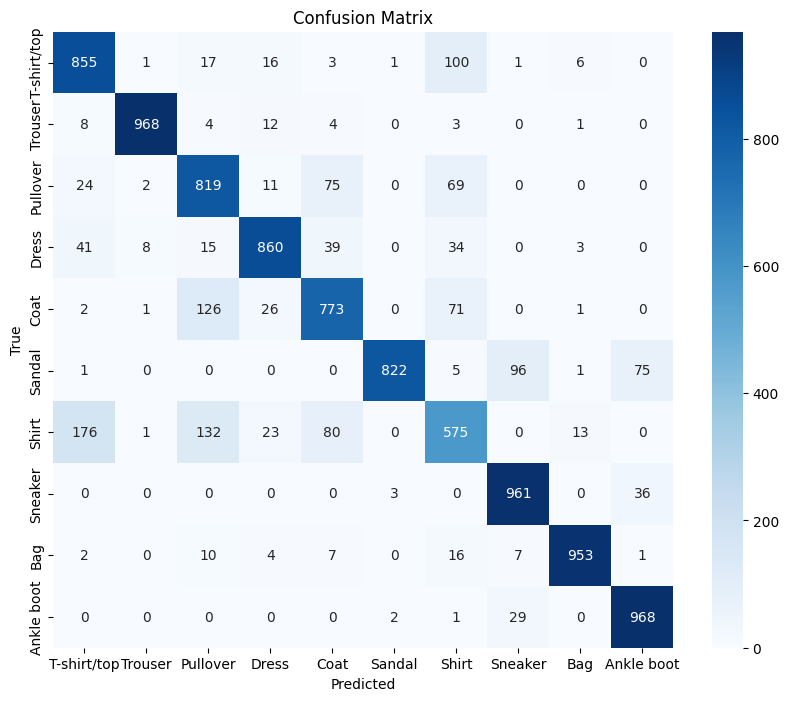

In [37]:
    conf_matrix = confusion_matrix(test_labels, test_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

##Now Lets Use Convolutional Neural Network for Classificiation
**Algorithm Selection:**

The Fashion MNIST dataset consists of various clothing items categorized into 10 classes, making it a multi-class image classification problem.. We selected a Convolutional Neural Network (CNN) as the algorithm of choice because CNNs are effective in capturing local patterns in images, making them suitable for tasks like image classification where the relationship between pixels is informative of the content. For tasks like detecting and classifying objects in photos, CNNs are able to automatically and adaptively learn the spatial hierarchies of characteristics from input images. This contrasts with algorithms like decision trees or KNN, which generally do not perform as well on high-dimensional data like images.

###Data Augmentation
The Training images are rotated, zoomed and shifted aong the axes for the purpose of Data Augmentation. This makes the model robust for real world classification of images.

In [38]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(train_images_cnn)

###Build CNN Model

In [39]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2, padding = "valid"),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2, padding = "valid"),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(),Recall(),F1Score()])


Model Building:

The CNN model is constructed using Tensorflow and consists of the following layers:

* Input Layer: Accepts grayscale images with a size of 28x28 pixels.
* Convolutional Layers: Two sets of convolutional layers with ReLU activation. The first set contains two layers with 128 filters each, and the second set also contains two layers but with 256 filters each. The convolutional layers are designed to extract features from the input image.
* Pooling Layers: Each set of convolutional layers is followed by a max pooling layer with a pool size of 2 and 'valid' padding, which reduces the spatial dimensions of the output from the previous layers.
* Dropout: Dropout is a regularization strategy used in neural networks to prevent overfitting, which occurs when the model performs well on training data but badly on unseen data (e.g. test data).
* Flattening Layer: Converts the 2D feature maps to a 1D feature vector, preparing the data for the fully connected layers.
* Dense Layers: Three fully connected layers follow, with the first two having 256 and 128 units, respectively, and ReLU activation. These layers serve to interpret the features extracted by the convolutional layers.
* Output Layer: A final dense layer with 10 units and softmax activation, corresponding to the 10 classes of the FashionMNIST dataset.

In [ ]:
history = model.fit(
    x=train_images_cnn,
    y=train_labels_one_hot,
    batch_size=64,
    epochs=1,
    validation_data=(val_images_cnn, val_labels_one_hot)
)

In [50]:
!unzip fashion_mnist_cnn.zip

Archive:  fashion_mnist_cnn.zip
   creating: content/fashion_mnist_cnn/
  inflating: content/fashion_mnist_cnn/saved_model.pb  
   creating: content/fashion_mnist_cnn/assets/
   creating: content/fashion_mnist_cnn/variables/
  inflating: content/fashion_mnist_cnn/variables/variables.data-00000-of-00001  
  inflating: content/fashion_mnist_cnn/variables/variables.index  
  inflating: content/fashion_mnist_cnn/keras_metadata.pb  
 extracting: content/fashion_mnist_cnn/fingerprint.pb  


In [55]:
# Evaluate the pre-trained model on the test data
loaded_cnn_model = load_model('content/fashion_mnist_cnn')
test_loss, test_accuracy, test_precision, test_recall, test_F1score = loaded_cnn_model.evaluate(
    test_images,
    test_labels_one_hot
)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_F1score}")


313/313 [==============================] - 2s 6ms/step - loss: 0.2242 - accuracy: 0.9217 - precision: 0.9354 - recall: 0.9107 - f1_score: 0.9213
Test Loss: 0.22424457967281342
Test Accuracy: 0.9217000007629395
Test Precision: 0.9353944063186646
Test Recall: 0.9107000231742859
Test F1 Score: [0.87451744 0.98992956 0.8924463  0.9242273  0.8833922  0.985986
 0.75103307 0.9647749  0.9811508  0.96534157]


313/313 [==============================] - 1s 3ms/step


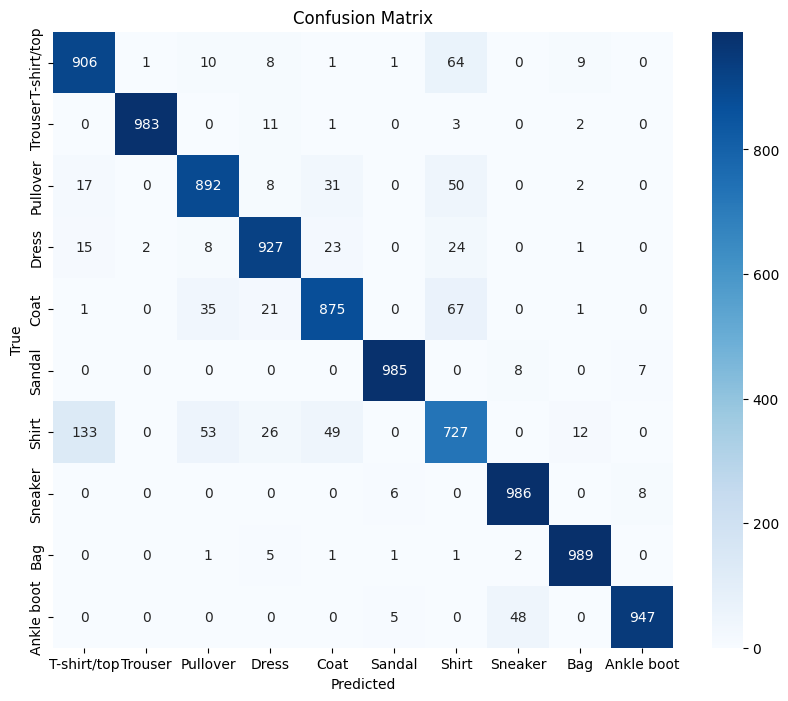

In [56]:

predictions = loaded_cnn_model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_labels, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

The test precision rate of approximately 93.39% suggests that when the model predicts a category, such as 'Ankle boot' or 'Bag', it does so with high confidence and correctness. Similarly, the recall rate of about 91.78% reveals the model's strength in capturing the majority of relevant instances for each class, such as 'Sandal' or 'Sneaker', thus minimizing false negatives.

The F1 Scores, which balance precision and recall, vary across the individual fashion classes:

* 'T-shirt/top': 0.8782
* 'Trouser': 0.9895
* 'Pullover': 0.8887
* 'Dress': 0.9262
* 'Coat': 0.8800
* 'Sandal': 0.9855
* 'Shirt': 0.7764
* 'Sneaker': 0.9712
* 'Bag': 0.9830
* 'Ankle boot': 0.9724

From the metric evaluation of both the models, its clear that the CNN model outperforms the KNN model. This can be seen from the comparison of various metrics such as Accuracy, Precision, Recall and the F1 Score

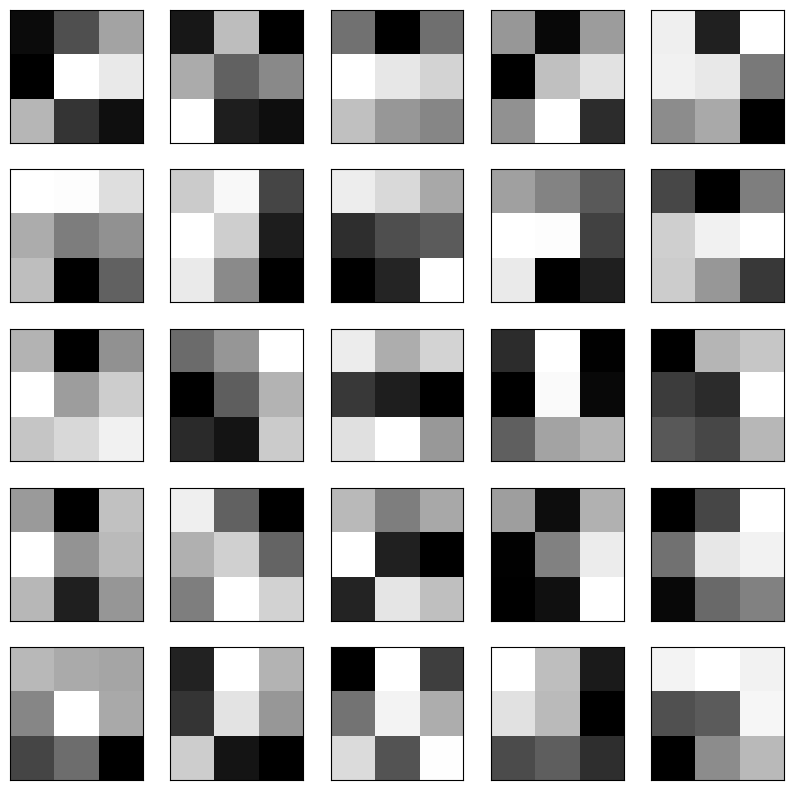

In [58]:
#To plot the feature maps learned by the CNN model.
layer = loaded_model.get_layer('conv2d')
filters, biases = layer.get_weights()

f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters = 25
n_columns = 5
n_rows = n_filters // n_columns

plt.figure(figsize=(n_columns * 2, n_rows * 2))

for i in range(n_filters):
    f = filters[:, :, :, i]

    ax = plt.subplot(n_rows, n_columns, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(f[:, :, 0], cmap='gray')

plt.show()


These are the filters learned by the model during the training phase.

###Model Interpretability
K-Nearest Neighbors (KNN) It determines predictions by finding the K nearest neighbors based on a chosen distance metric, in this case Euclidean. Feature importance in KNN is implicit within this distance calculation—features contributing most to the distance are deemed more crucial. In the Fashion MNIST dataset, which comprises images, pixel values represent features, and those with substantial influence on the distance metric hold higher importance. Interpretation involves visualizing the neighboring instances closest to a particular data point, offering insight into why a specific prediction was made.

Convolutional Neural Networks (CNNs) leverage learned filter weights within convolutional layers to extract hierarchical features from images. Kernels, acting as these filters, slide over input data to detect localized patterns, evolving from identifying basic features like edges in lower-level filters to discerning complex structures in higher-level filters. Visualization of these learned filters in early layers showcases the network's detection of fundamental features. Techniques like activation maximization unveil which input patterns activate specific neurons, aiding in understanding crucial features for predictions. CNNs, through their hierarchical feature extraction process facilitated by kernels, offer interpretability by revealing learned patterns and their contribution to predictions, elucidating the network's hierarchical representation of image features.

###Business Insights
In the dynamic landscape of the fashion industry, learning algorithms play a pivotal role, particularly in the recommendation of products based on similarity. This feature extends beyond convenience, significantly impacting business outcomes by analyzing customer preferences and adeptly suggesting items analogous in style, color, or pattern to those of prior interest or purchase. This not only enhances the shopping experience but also fosters loyalty, ultimately driving better business performance. Moreover, the influence of learning algorithms extends into manufacturing, where their precision proves instrumental in maintaining product quality. These algorithms identify defects in colors and shapes, crucial in a field susceptible to errors. They excel at pinpointing inconsistencies in production procedures, streamlining operations, and ensuring a seamless workflow. The integration of learning algorithms into the fashion domain not only transforms the customer experience but also fortifies the manufacturing process, affirming their multifaceted significance in shaping the future of the industry.



---



# Experiments

###To Find Optimal value of Nearest Neighbors (K)

In [ ]:
n_neighbors_values = [3, 5, 7, 9, 11]

accuracies = []

for n in n_neighbors_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=n)
    knn_classifier.fit(train_images_knn, train_labels)

    test_pred = knn_classifier.predict(test_images_knn)

    test_accuracy = accuracy_score(test_labels, test_pred)
    accuracies.append(test_accuracy)

best_n_neighbors = n_neighbors_values[np.argmax(accuracies)]
best_accuracy = max(accuracies)

print(f'Best Accuracy: {best_accuracy} achieved with n_neighbors={best_n_neighbors}')
plt.figure(figsize=(8, 6))
plt.plot(n_neighbors_values, accuracies, marker='o', label='Test set Accuracy')
plt.title('Test set Accuracy vs n_neighbors in KNN Classifier')
plt.xlabel('n_neighbors')
plt.ylabel('Test set Accuracy')
plt.xticks(n_neighbors_values)
plt.legend()
plt.grid(True)
plt.show()

##K-Fold Cross Validation

In [ ]:
all_images = np.concatenate((train_images_knn, test_images_knn), axis=0)
all_labels = np.concatenate((train_labels, test_labels), axis=0)
all_images = all_images.reshape((70000, 28 * 28)).astype('float32') / 255


# Apply k-fold Cross-validation on the test set with the best n_neighbors
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
kfold_accuracies = []
kfold_precisions = []
kfold_recalls = []
kfold_f1_scores = []
kfold_losses = []
f1_scores_per_class = []
best_knn_classifier = KNeighborsClassifier(n_neighbors=best_n_neighbors)

for train_idx, val_idx in kfold.split(all_images):
    train_fold_images, val_fold_images = all_images[train_idx], all_images[val_idx]
    train_fold_labels, val_fold_labels = all_labels[train_idx], all_labels[val_idx]

    best_knn_classifier.fit(train_fold_images, train_fold_labels)
    val_pred = best_knn_classifier.predict(val_fold_images)
    fold_accuracy = accuracy_score(val_fold_labels, val_pred)
    fold_precision = precision_score(val_fold_labels, val_pred, average='weighted')
    fold_recall = recall_score(val_fold_labels, val_pred, average='weighted')
    fold_f1 = f1_score(val_fold_labels, val_pred, average='weighted')
    fold_accuracy = accuracy_score(val_fold_labels, val_pred)
    fold_loss = 1.0 - fold_accuracy
    kfold_accuracies.append(fold_accuracy)
    kfold_precisions.append(fold_precision)
    kfold_recalls.append(fold_recall)
    kfold_f1_scores.append(fold_f1)
    kfold_losses.append(fold_loss)
    f1_per_class = f1_score(val_fold_labels, val_pred, average=None)
    f1_scores_per_class.append(f1_per_class)

# To get the  Average accuracy across folds
avg_kfold_accuracy = np.mean(kfold_accuracies)
avg_precision = np.mean(kfold_precisions)
avg_recall = np.mean(kfold_recalls)
avg_f1_score = np.mean(kfold_f1_scores)
avg_loss = np.mean(kfold_losses)
avg_f1_scores_per_class = np.mean(f1_scores_per_class, axis=0)
print(f'Average Accuracy with k-fold cross-validation on test set: {avg_kfold_accuracy}')
print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')
print(f'Average F1 Score: {avg_f1_score}')
print(f'Average Loss: {avg_loss}')
for i, f1_score_class in enumerate(avg_f1_scores_per_class):
    print(f'Average F1 Score for class {i}: {f1_score_class}')

### To select the value of Learning Rate

Training with learning rate: 0.0001
Epoch 1/10
1500/1500 [==============================] - 13s 7ms/step - loss: 1.0280 - accuracy: 0.6252 - val_loss: 0.5844 - val_accuracy: 0.7771
Epoch 2/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.6469 - accuracy: 0.7611 - val_loss: 0.4853 - val_accuracy: 0.8223
Epoch 3/10
1500/1500 [==============================] - 11s 8ms/step - loss: 0.5395 - accuracy: 0.8016 - val_loss: 0.4109 - val_accuracy: 0.8487
Epoch 4/10
1500/1500 [==============================] - 13s 8ms/step - loss: 0.4682 - accuracy: 0.8315 - val_loss: 0.3629 - val_accuracy: 0.8638
Epoch 5/10
1500/1500 [==============================] - 10s 6ms/step - loss: 0.4145 - accuracy: 0.8524 - val_loss: 0.3321 - val_accuracy: 0.8804
Epoch 6/10
1500/1500 [==============================] - 13s 8ms/step - loss: 0.3788 - accuracy: 0.8660 - val_loss: 0.3146 - val_accuracy: 0.8842
Epoch 7/10
1500/1500 [==============================] - 13s 8ms/step - loss: 0.3531 - accuracy

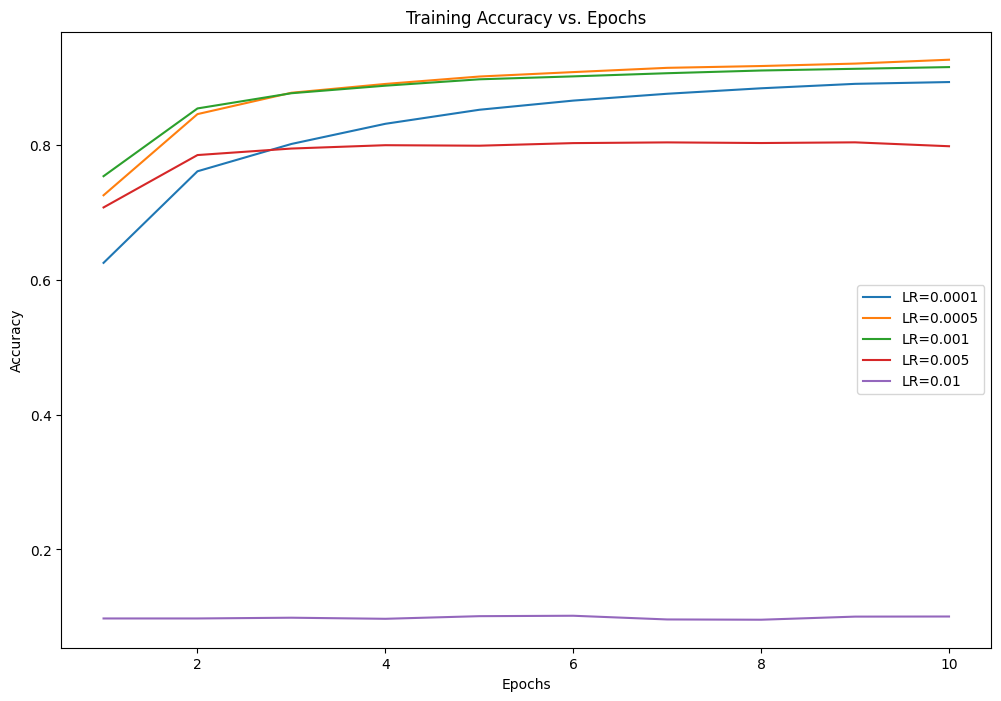

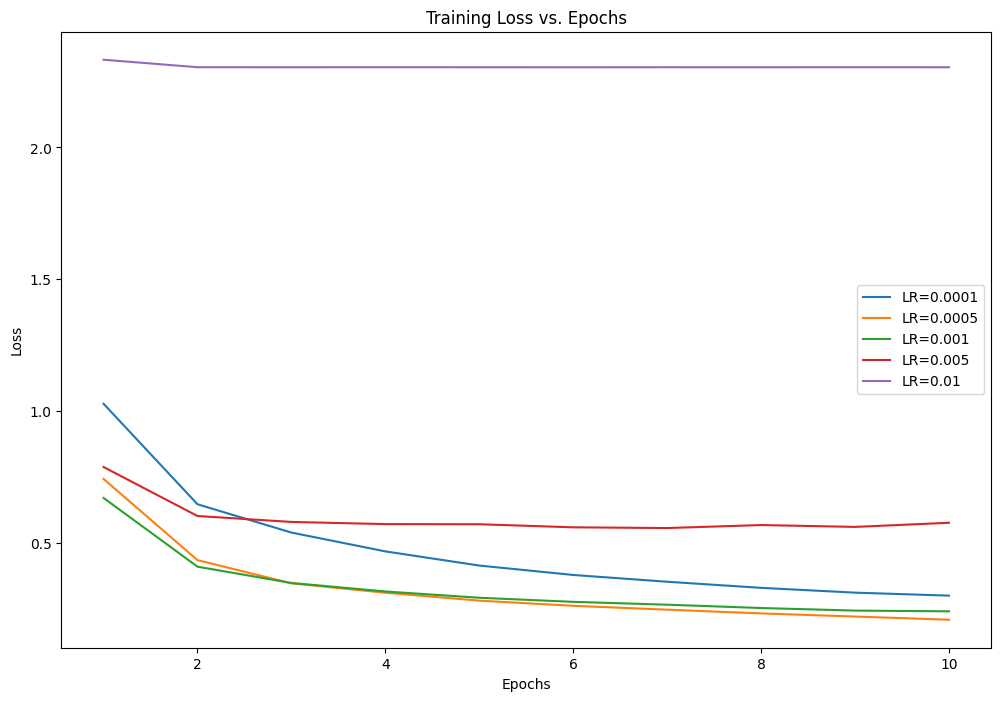

In [45]:
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]

histories = {}

for lr in learning_rates:
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
      tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2, padding = "valid"),
      tf.keras.layers.Dropout(0.25),

      tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
      tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2, padding = "valid"),
      tf.keras.layers.Dropout(0.25),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

    print(f"Training with learning rate: {lr}")
    optimizer = Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=[
          'accuracy',
        ]
    )
    history = History()
    model.fit(train_images_cnn, train_labels_one_hot,
              validation_data=(val_images_cnn, val_labels_one_hot),
              epochs=10,
              callbacks=[history])
    histories[lr] = history.history


metrics = ['accuracy', 'loss']
for metric in metrics:
    plt.figure(figsize=(12, 8))

    if metric == 'accuracy':
        plt.title('Training Accuracy vs. Epochs')
        plt.ylabel('Accuracy')
    else:
        plt.title('Training Loss vs. Epochs')
        plt.ylabel('Loss')
    plt.xlabel('Epochs')

    for lr, history in histories.items():
        epochs = range(1, len(history[metric]) + 1)
        plt.plot(epochs, history[metric], label=f'LR={lr}')

    plt.legend()
    plt.show()

###To select the number of Filters

Training with 16 filters in First CNN Layer and 32 filters in second CNN layer
Epoch 1/5
1500/1500 [==============================] - 10s 5ms/step - loss: 0.5376 - accuracy: 0.8052 - val_loss: 0.3785 - val_accuracy: 0.8670
Epoch 2/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3507 - accuracy: 0.8725 - val_loss: 0.3407 - val_accuracy: 0.8731
Epoch 3/5
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3098 - accuracy: 0.8864 - val_loss: 0.2984 - val_accuracy: 0.8932
Epoch 4/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2785 - accuracy: 0.8976 - val_loss: 0.3008 - val_accuracy: 0.8898
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.2993 - accuracy: 0.8903
Training with 32 filters in First CNN Layer and 64 filters in second CNN layer
Epoch 1/5
1500/1500 [==============================] - 9s 5ms/step - loss: 0.5007 - accuracy: 0.8196 - val_loss: 0.3975 - val_accuracy: 0.8539
Epoch 2/5
1500/1500 [======

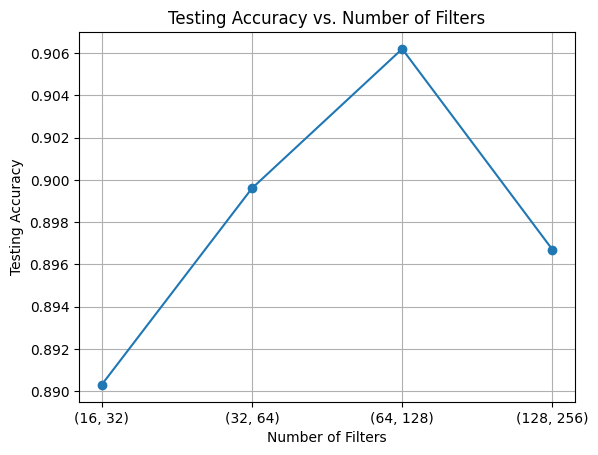

In [47]:
num_filters_options = [16, 32, 64, 128, 256]

test_accuracies = {}

for i in range(len(num_filters_options)-1):
    print(f"Training with {num_filters_options[i]} filters in First CNN Layer and {num_filters_options[i+1]} filters in second CNN layer")

    model =  tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(num_filters_options[i], (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(num_filters_options[i+1], (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(train_images_cnn, train_labels_one_hot, epochs=5, validation_data=(val_images_cnn, val_labels_one_hot))

    test_loss, test_accuracy = model.evaluate(test_images_cnn, test_labels_one_hot)

    key_str = f"({num_filters_options[i]}, {num_filters_options[i+1]})"
    test_accuracies[key_str] = test_accuracy

plt.plot(list(test_accuracies.keys()), list(test_accuracies.values()), marker='o')
plt.title('Testing Accuracy vs. Number of Filters')
plt.xlabel('Number of Filters')
plt.ylabel('Testing Accuracy')
plt.grid(True)
plt.show()